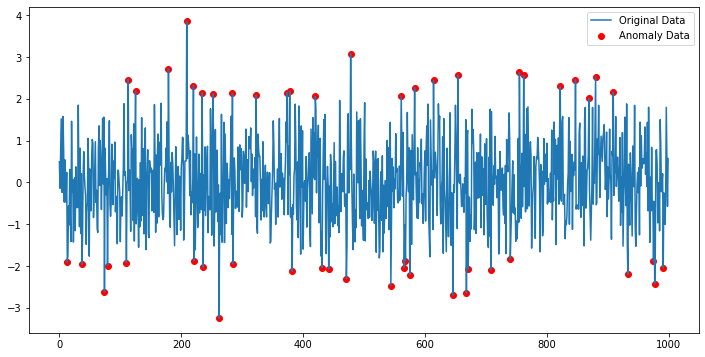

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
# quick example
# Generate some data for demonstration
np.random.seed(42)
data = pd.Series(np.random.normal(loc=0, scale=1, size=1000))

# Fit the isolation forest model to the data
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05), random_state=42) # contamination: means 5% data are the anomaly data
model.fit(data.values.reshape(-1, 1))

# Make predictions on the data
anomaly_mask = model.predict(data.values.reshape(-1, 1)) == -1
anomaly_data = data[anomaly_mask]

# Plot the original data along with the detected anomalies
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data, label='Original Data')
ax.scatter(anomaly_data.index, anomaly_data, color='r', label='Anomaly Data')
ax.legend()
plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from enum import Enum
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import random
import datetime
import warnings
warnings.filterwarnings('ignore')
     

# Prepare Data functions
# get mean features per second
def get_mean_features_sec(df, mean_features, groupby_features):
  for column_name in mean_features:
    new_column_name = 'mean_second_' + column_name
    df[new_column_name] = df.groupby(groupby_features)[column_name].transform('mean')
  return df

# get mean features per mintue
def get_mean_features_minute(df, mean_features, groupby_features):
  for column_name in mean_features:
    new_column_name = 'mean_minute_' + column_name
    df[new_column_name] = df.groupby(groupby_features)[column_name].transform('mean')
  return df


# add shift features 
def get_shift(n, columns, df, session_column_name):
  features_ = []
  df_data = df
  for i in range(n):
    for c in columns:
      new_feature_name = c + '_shifted_' + str(i+1)
      df_data[new_feature_name] = df_data.groupby(session_column_name)[c].shift(i+1)
      features_ = features_ + [new_feature_name]
  return df_data, features_

df_data = pd.read_csv('./Train_Mouse.csv')
df_data.shape

# sorted buy timestamp
df_data = df_data.sort_values('timestamp').reset_index()
df_data['index'] = df_data.index

# labeling user_id and session_id
user_id_array = df_data['user_id'].unique()
user_id_map = {val:idx for idx,val in enumerate(user_id_array)}
df_data['user_id_new'] = df_data['user_id'].map(lambda x: user_id_map[x])
session_id_array = df_data['session_id'].unique()
session_id_map = {val:idx for idx,val in enumerate(session_id_array)}
df_data['session_id_new'] = df_data['session_id'].map(lambda x: session_id_map[x])

# labeling + one-hot for event_type
event_list = ['', 'RELEASE', 'MOVE', 'WHEEL', 'DRAG', 'CLICK']
df_data['e'] = df_data['event_type'].map(lambda x: event_list[x])
one_hot_df = pd.get_dummies(df_data['e'], prefix='event')
df_data = pd.concat([df_data, one_hot_df], axis=1)
categorial_cols = ['event_MOVE', 'event_WHEEL', 'event_DRAG', 'event_CLICK']

# time features
df_data['datetime'] = pd.to_datetime(df_data['timestamp'], unit='ms')
df_data['day'] = df_data['datetime'].dt.date
df_data['hour'] = df_data['datetime'].dt.hour
df_data['minute'] = df_data['datetime'].dt.minute
df_data['second'] = df_data['datetime'].dt.second
time_features = ['hour', 'minute', 'second']

# timestamp features
df_data['time_stamp_min'] = df_data.groupby('session_id_new')['timestamp'].transform('min')
df_data['time_stamp'] = df_data['timestamp'] - df_data['time_stamp_min']
df_data['time_diff'] = df_data.groupby('session_id_new')['timestamp'].diff()

# calculate the x_diff y_diff and distance btw (x,y)
df_data['x_diff'] = df_data.groupby('session_id_new')['screen_x'].diff()
df_data['y_diff'] = df_data.groupby('session_id_new')['screen_y'].diff()
df_data['xy_diff'] = np.sqrt(df_data['x_diff']**2 + df_data['y_diff']**2)

# calculate the speed
df_data['x_speed'] = np.abs(df_data['x_diff'] / df_data['time_diff'])
df_data['y_speed'] = np.abs(df_data['y_diff'] / df_data['time_diff'])
df_data['xy_speed'] = df_data['xy_diff'] / df_data['time_diff']

mean_features = ['x_speed', 'y_speed', 'xy_speed', 'screen_x', 'screen_y', 'event_type']
df_data = get_mean_features_sec(df_data.dropna(), mean_features, ['session_id_new', 'day', 'hour', 'minute', 'second'])

# we take 30 step
aggragation_cols = [ 'mean_second_x_speed', 'mean_second_y_speed', 'mean_second_xy_speed', 
                     'mean_second_screen_x', 'mean_second_screen_y', 'mean_second_event_type'
                  ]
n_step = 25
df_data, features_add = get_shift(n_step, aggragation_cols, df_data, 'session_id_new')

In [36]:
df_data.columns

Index(['index', 'uid', 'session_id', 'user_id', 'timestamp', 'event_type',
       'screen_x', 'screen_y', 'user_id_new', 'session_id_new',
       ...
       'mean_second_xy_speed_shifted_24', 'mean_second_screen_x_shifted_24',
       'mean_second_screen_y_shifted_24', 'mean_second_event_type_shifted_24',
       'mean_second_x_speed_shifted_25', 'mean_second_y_speed_shifted_25',
       'mean_second_xy_speed_shifted_25', 'mean_second_screen_x_shifted_25',
       'mean_second_screen_y_shifted_25', 'mean_second_event_type_shifted_25'],
      dtype='object', length=186)

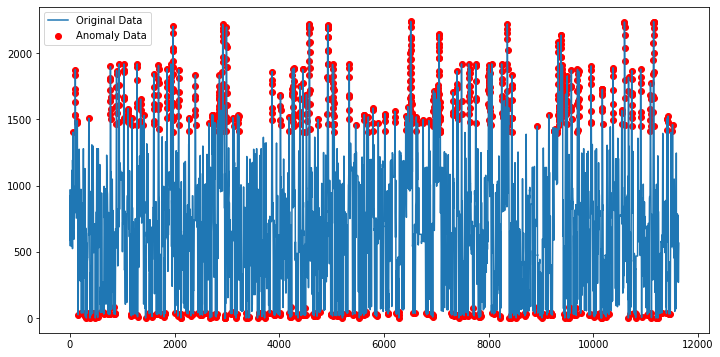

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Fit the isolation forest model to the data
model = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.10), random_state=42)
model.fit(df_data['screen_x'].values.reshape(-1, 1))

# Make predictions on the data
anomaly_mask = model.predict(df_data['screen_x'].values.reshape(-1, 1)) == -1
anomaly_data = df_data['screen_x'][anomaly_mask]

# Plot the original data along with the detected anomalies
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_data['screen_x'], label='Original Data')
ax.scatter(anomaly_data.index, anomaly_data, color='r', label='Anomaly Data')
ax.legend()
plt.show()

In [51]:
# Evaluate model using ODR
from scipy.odr import ODR, Model, Data

def linear_model(params, x):
    return params[0]*x + params[1]

def residual(params, x, y):
    return y - linear_model(params, x)

x = np.arange(len(df_data['screen_x']))
y = model.decision_function(df_data['screen_x'].values.reshape(-1, 1))

odr_model = Model(linear_model)
odr_data = Data(x, y)

odr = ODR(odr_data, odr_model, beta0=[1.0, 0.0])
output = odr.run()

In [52]:
# Print results
print("Slope: ", output.beta[0])
print("Intercept: ", output.beta[1])
print("Standard error of slope: ", output.sd_beta[0])
print("Standard error of intercept: ", output.sd_beta[1])

Slope:  -4.3753404171104416e-07
Intercept:  0.06561042689527727
Standard error of slope:  1.4046389778565824e-07
Standard error of intercept:  0.000933607423029776


In [45]:
'''
use the orthogonal distance regression (ODR) to evaluate the performance of the Isolation Forest model is because ODR is a robust regression method that can handle outliers effectively. In this case, we can use ODR to fit a line to the scatter plot of the predicted anomaly scores versus the true labels.

The slope and intercept of the fitted line provide us with information about how well the Isolation Forest model is performing. Ideally, the slope should be close to 1, and the intercept should be close to 0. This means that the predicted anomaly scores are linearly related to the true labels, and there is no systematic bias in the predictions.

The standard error of slope and standard error of intercept tell us about the precision of the slope and intercept estimates. Lower values of these parameters indicate higher precision and hence better performance. Overall, the ODR method provides a quantitative way to evaluate the performance of the Isolation Forest model and can be useful for comparing different models or tuning hyperparameters.
'''

'\nuse the orthogonal distance regression (ODR) to evaluate the performance of the Isolation Forest model is because ODR is a robust regression method that can handle outliers effectively. In this case, we can use ODR to fit a line to the scatter plot of the predicted anomaly scores versus the true labels.\n\nThe slope and intercept of the fitted line provide us with information about how well the Isolation Forest model is performing. Ideally, the slope should be close to 1, and the intercept should be close to 0. This means that the predicted anomaly scores are linearly related to the true labels, and there is no systematic bias in the predictions.\n\nThe standard error of slope and standard error of intercept tell us about the precision of the slope and intercept estimates. Lower values of these parameters indicate higher precision and hence better performance. Overall, the ODR method provides a quantitative way to evaluate the performance of the Isolation Forest model and can be use

In [53]:
normal_data = df_data['screen_x'][~anomaly_mask]
normal_data.describe()

count    10362.000000
mean       665.994872
std        343.491242
min         39.928240
25%        400.666700
50%        650.000000
75%        921.000000
max       1454.847700
Name: screen_x, dtype: float64

In [54]:
df_data['screen_x'].describe()

count    11513.000000
mean       719.157762
std        435.726740
min          0.000000
25%        395.200000
50%        672.000000
75%        986.000000
max       2239.980500
Name: screen_x, dtype: float64